# Prepare

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import qutip as qt
from copy import deepcopy

import experiments as meas
from experiments.MM_dual_rail_base import MM_dual_rail_base
from fitting.fit_display_classes import GeneralFitting
from fitting.wigner import WignerAnalysis

from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

user = "connie"
print("Welcome", user)


station = MultimodeStation(
    user=user,
    # experiment_name = "250119_qec",
    experiment_name = "260128_qsim",
)

USE_QUEUE = True

mm_base_calib = MM_dual_rail_base(station.hardware_cfg, station.soc)
# multiphoton_cfg_thisrun = AttrDict(deepcopy(mm_base_calib.multiphoton_cfg))

Importing all classes from  D:\python\multimode_expts\experiments\dual_rail
Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']
Server status: healthy
Pending jobs: 0
Welcome connie
[STATION] Using main hardware_config version: CFG-HW-20260203-00006
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260203-00003
[STATION] Using main floquet_storage_swap version: CFG-FL-20260203-00010
Data, plots, logs will be stored in: D:\experiments\260128_qsim
Hardware configs will be read from D:\python\multimode_expts\configs\versi

# Setting up the Wigner tomography

## Single shot

In [2]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    # cavity_freq=4984.373226159381,
    # cavity_gain=400,
    # cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

Job submitted: JOB-20260203-00140 (queue position: 1)

[0.1s] Job JOB-20260203-00140: pending

[18.2s] Job JOB-20260203-00140: running
[WORKER] Loading HistogramExperiment from experiments.single_qubit.single_shot
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260203-00140_HistogramExperiment.h5
[WORKER] Running experiment...
['qubit', 'ge', 'hpi', 0]
['wait', 1.6371885401046262]
['qubit', 'ge', 'hpi', 180]
100%|█████████████████████████████████████| 5000/5000 [00:10<00:00, 499.21it/s]
['qubit', 'ge', 'hpi', 0]
['wait', 1.6371885401046262]
['qubit', 'ge', 'hpi', 180]
 66%|████████████████████████▏            | 3276/5000 [00:06<00:03, 498.97it/s]
[42.5s] Job JOB-20260203-00140: completed
100%|█████████████████████████████████████| 5000/5000 [00:10<00:00, 499.22it/s]
Unrotated:
Ig -84.17532467532467 +/- 25.518701351929685 	 Qg -60.23701298701299 +/- 24.079368625644193 	 Amp g 103.50837172805828
Ie 19.664502164502164 +/- 29.550269809344837 	 Qe -0.26515151515151514 +/- 

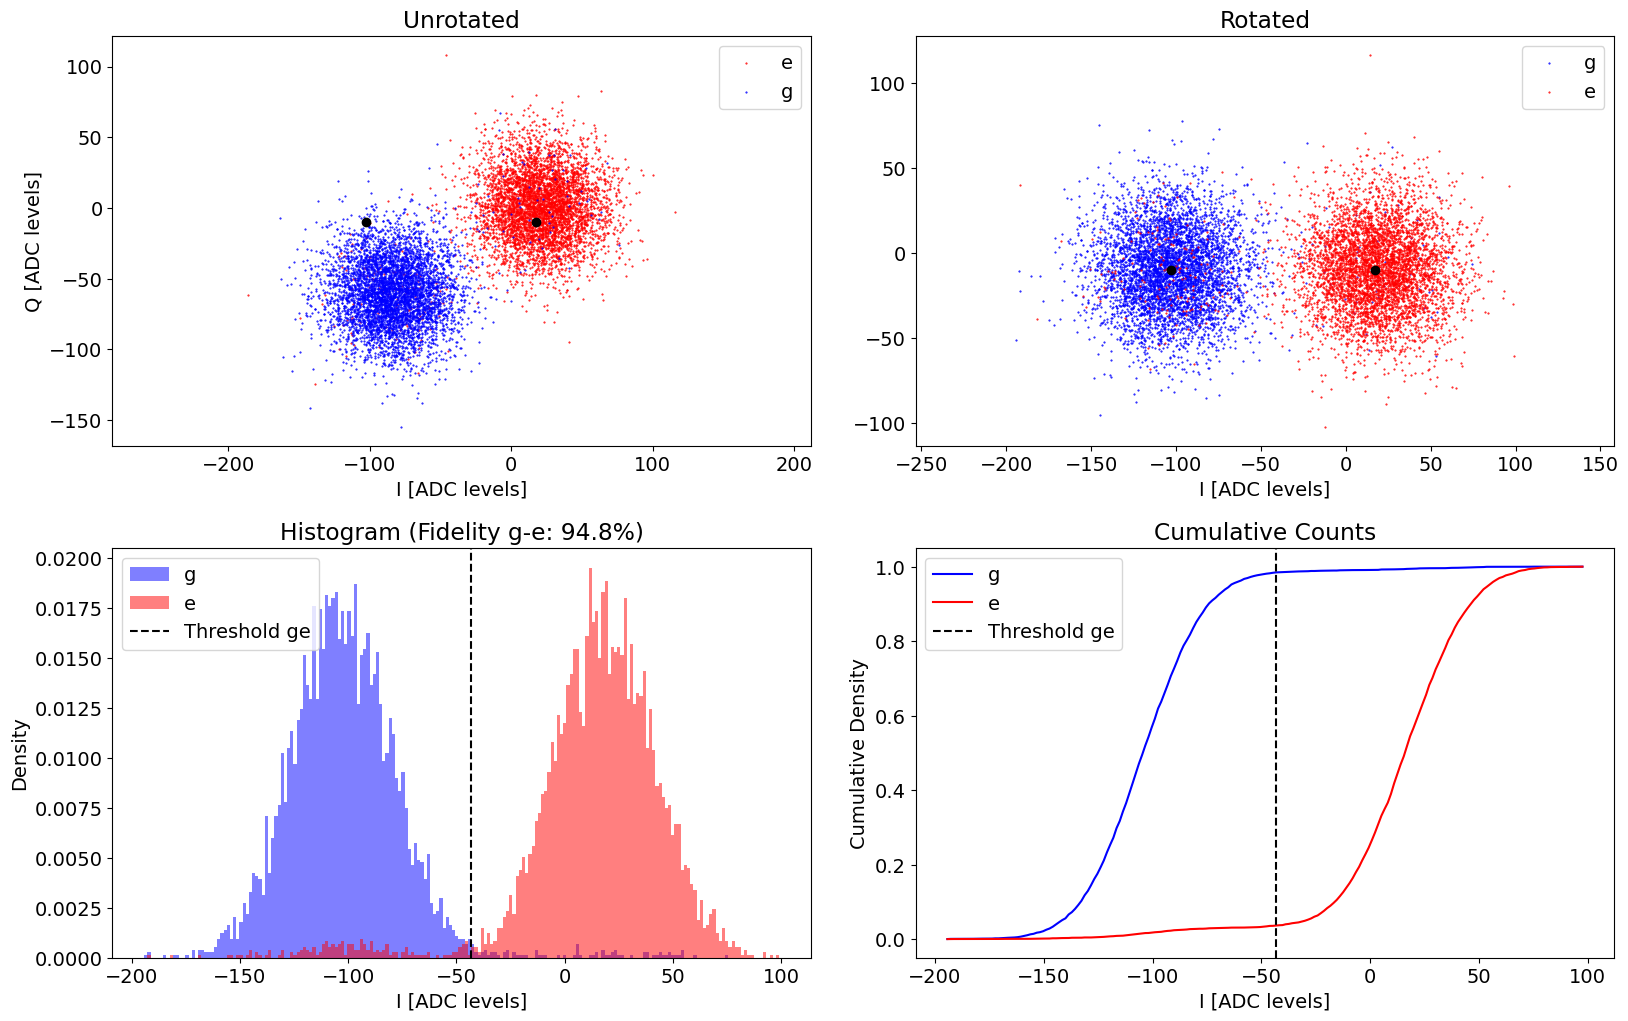

Plot saved to D:\experiments\260128_qsim\plots\2026-02-03_15-48-16_histogram.png
Plot reference appended to D:\experiments\260128_qsim\logs\2026-02-03.md
ge fidelity (%): 94.8192718543709
rotation angle (deg): -30.008238423052155
threshold ge: -43.220583393766674


In [3]:
# Execute
# =================================
ss_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
)

ss = ss_runner.execute(
    go_kwargs=dict(analyze=False, display=False),
    check_f=False,
    active_reset=False, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
    relax_delay=2000,
    # active_reset=True,
    # relax_delay=200,
)
ss.display(station)

In [4]:
station.snapshot_hardware_config(update_main=True)
station.preview_config_update()

[CONFIG] Created new hardware_config version CFG-HW-20260203-00006
[CONFIG] Updated main hardware_config to CFG-HW-20260203-00006
Comparing configurations:
Parent config file: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260202-00012.yml
Key 'device.readout.phase' differs:
  Old value (config1): [116.80805199604343]
  New value (config2): [86.79981357299127]
Key 'device.readout.threshold' differs:
  Old value (config1): [-43.579202343000475]
  New value (config2): [-43.220583393766674]
Key 'device.readout.threshold_list' differs:
  Old value (config1): [[-43.579202343000475]]
  New value (config2): [[-43.220583393766674]]
Key 'device.readout.confusion_matrix_without_reset' differs:
  Old value (config1): [0.9837999999999995, 0.016200000000000547, 0.03699999999999994, 0.9630000000000001]
  New value (config2): [0.9846, 0.01539999999999997, 0.03640728145629127, 0.9635927185437088]
Key 'device.readout.Ie' differs:
  Old value (config1): [15.409810234007871]
  New va

## Photon Number Resolved  Spectroscopy

This is used to check that the fock states are well prepared before we do the tomography

In [ ]:
photon_number_spectro_defaults = AttrDict(dict(
    start=3560, 
    step=0.1,
    expts=200,
    reps=2000,
    rounds=1,
    length=1,
    gain=400,
    sigma=0.1,
    qubits=[0],
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,
))

photon_number_spectro_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment,
    default_expt_cfg=photon_number_spectro_defaults,
    job_client=client,
    use_queue=USE_QUEUE,
    # use_queue=False,
)

In [ ]:
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=1)
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
print(f"pre_sweep_pulse: {pre_sweep_pulse}")

pre_sweep_pulse: [[3563.0529142488185, 3419.1692649212164, 1998.6157879732], [3287, 3025, 8000], [0, 0, 0.5809047339334457], [0, 0, 0], [2, 2, 0], ['gauss', 'gauss', 'flat_top'], [0.035, 0.035, 0.005]]


In [ ]:
span = 5
expt = 100
step = span / expt
start = station.hardware_cfg.device.qubit.f_ge[0] - span*0.9
length = 15
gain=25

if tomo_expts_to_run['photon_number_spectro']:
    photon_number_spectro = photon_number_spectro_runner.execute(
        go_kwargs=dict(analyze=True, display=True, save=True),
        pre_sweep_pulse=pre_sweep_pulse,
        prepulse=True,
        gate_based=False,
        start=start,
        length=length,
        sigma=1.,
        gain=gain,
        step=step,
        expts=expt,
        relax_delay=500,
    )

Job submitted: JOB-20260122-00049 (queue position: 1)

[0.1s] Job JOB-20260122-00049: pending

[2.1s] Job JOB-20260122-00049: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00049_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
 98%|███████████████████████████████▍| 196560/200000 [01:42<00:01, 1914.05it/s]
[113.0s] Job JOB-20260122-00049: completed
100%|████████████████████████████████| 200000/200000 [01:44<00:00, 1913.82it/s]
Saving D:\experiments\250119_qec\data\JOB-20260122-00049_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\250119_qec\expt_objs\JOB-20260122-00049_expt.pkl

Job completed! Data: D:\experiments\250119_qec\data\JOB-20260122-00049_PulseProbeSpectroscopyExperiment.h5


Found peak in amps at [MHz] 3562.3433397738636, HWHM 0.22946797090567983
Found peak in I at [MHz] 3562.3429319768056, HWHM 0.22773836479371548
Found peak in Q at [MHz] 3559.118209281669, HWHM -0.0048393347302186605


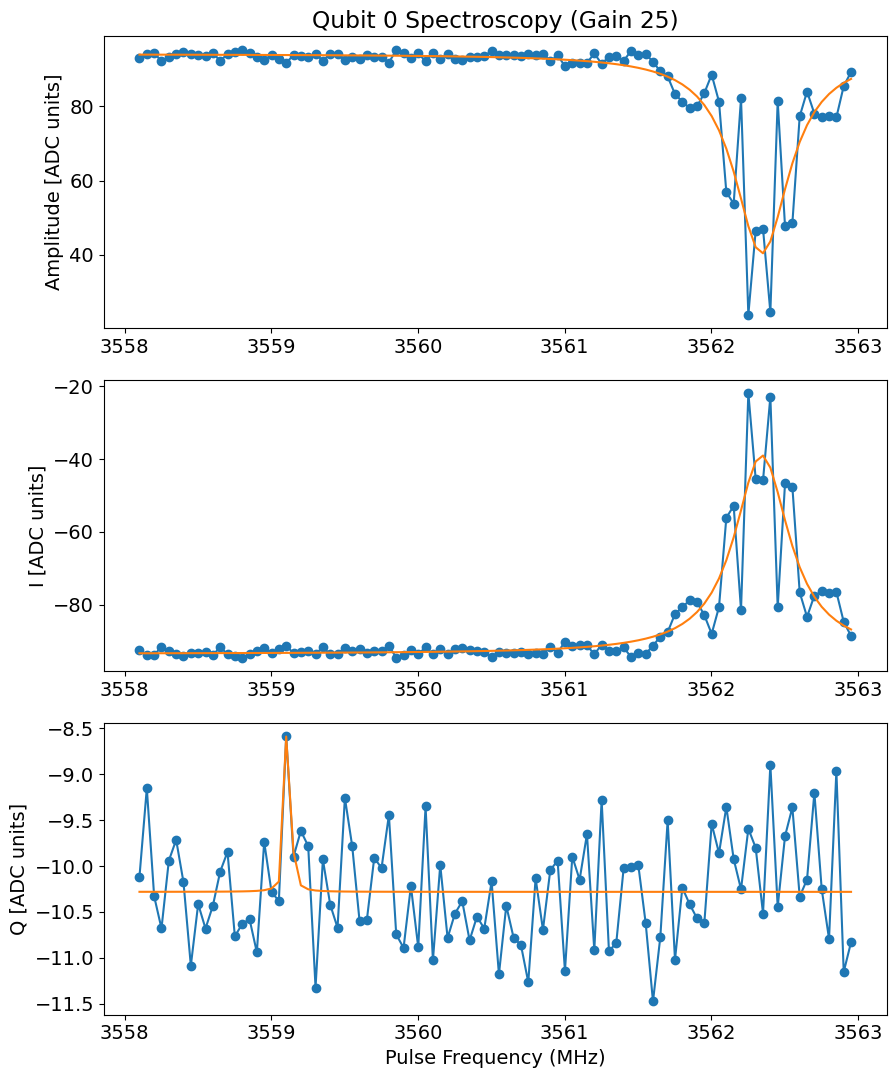

In [ ]:
if tomo_expts_to_run['photon_number_spectro']:
    if USE_QUEUE:
        photon_number_spectro.display()

## Parity Delay

In [ ]:
parity_delay_defaults = AttrDict(dict(
    start=0.01,
    step=0.05,
    expts=50,
    reps=250,
    rounds=1,
    qubits=[0],
    parity_fast=True,
    normalize=False,
    active_reset=False,
    man_reset=True,
    gate_based=False,
    storage_reset=True,
    man_mode_no=1,
    relax_delay=2500, 
    param_to_calib='length', # length or ac_stark_shift 
    shift_sign=1, # 1 or -1 for ac stark shift direction
    ))


def parity_delay_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    if 'param_to_calib' in expt_cfg and expt_cfg.param_to_calib =='ac_stark_shift':
        expt_cfg.prepulse = False
        expt_cfg.pre_sweep_pulse = []
    elif 'param_to_calib' in expt_cfg and expt_cfg.param_to_calib =='length':
        expt_cfg.prepulse = True
        pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=expt_cfg.man_mode_no, photon_no=1)
        pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, station.hardware_cfg).pulse.tolist()
        expt_cfg.pre_sweep_pulse = pre_sweep_pulse
    return expt_cfg

def parity_delay_postproc(station, expt):
    from fitting.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(expt.data, config = expt.cfg)
    length_rabi_analysis.analyze(fitparams = [100, 0.1, 0, None, None, None])
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')
    expt_cfg = expt.cfg.expt
    man_mode_no = expt_cfg.man_mode_no
    shift_sign = expt_cfg.shift_sign


    if expt_cfg.param_to_calib == 'length':
        delay = length_rabi_analysis.results['pi_length']
        print(f'Fitted revival time: {delay} us')
        old_delay = station.hardware_cfg.device.manipulate.revival_time[man_mode_no - 1]
        station.hardware_cfg.device.manipulate.revival_time[man_mode_no - 1] = delay
        print(f'Updated revival time for mode {man_mode_no}: {old_delay} -> {station.hardware_cfg.device.manipulate.revival_time[man_mode_no - 1]}')

    elif expt_cfg.param_to_calib == 'ac_stark_shift': 
        freq = length_rabi_analysis.data['fit_avgi'][1]
        print(f'Fitted ac Stark shift: {freq} MHz')
        old_freq = station.hardware_cfg.device.manipulate.revival_stark_shift[man_mode_no - 1]
        station.hardware_cfg.device.manipulate.revival_stark_shift[man_mode_no - 1] += shift_sign * freq
        print(f'Updated ac Stark shift for mode {man_mode_no}: {old_freq} -> {station.hardware_cfg.device.manipulate.revival_stark_shift[man_mode_no - 1]}')

    


### Calibrate first the AC stark shift

Manipulate in 0, qubit should not rotate

this is calibrating the virtual Z to correct from rotating frame to bare frame

[autoreload of experiments.qubit_cavity.single_mode_wigner_tomography failed: Traceback (most recent call last):
  File "C:\Users\26049\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\26049\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 580, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "d:\python\multimode_expts\.pixi\envs\default\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1133, in get_code
  File "<frozen importlib._bootstrap_external>", line 1063, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "D:\python\multimode_expts\

Job submitted: JOB-20260128-00080 (queue position: 1)

[0.1s] Job JOB-20260128-00080: pending

[2.1s] Job JOB-20260128-00080: running
[WORKER] Loading ParityDelayExperiment from experiments.single_qubit.parity_phase
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260128-00080_ParityDelayExperiment.h5
[WORKER] Running experiment...
  0%|                                                  | 0/100 [00:00<?, ?it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  1%|▍                                         | 1/100 [00:00<00:34,  2.91it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  2%|▊                                         | 2/100 [00:00<00:33,  2.89it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  3%|█▎                                        | 3/100 [00:01<00:33,  2.90it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  4%|█▋                                        | 4/100 [00:01<00:33,  2.88it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  5%|██            

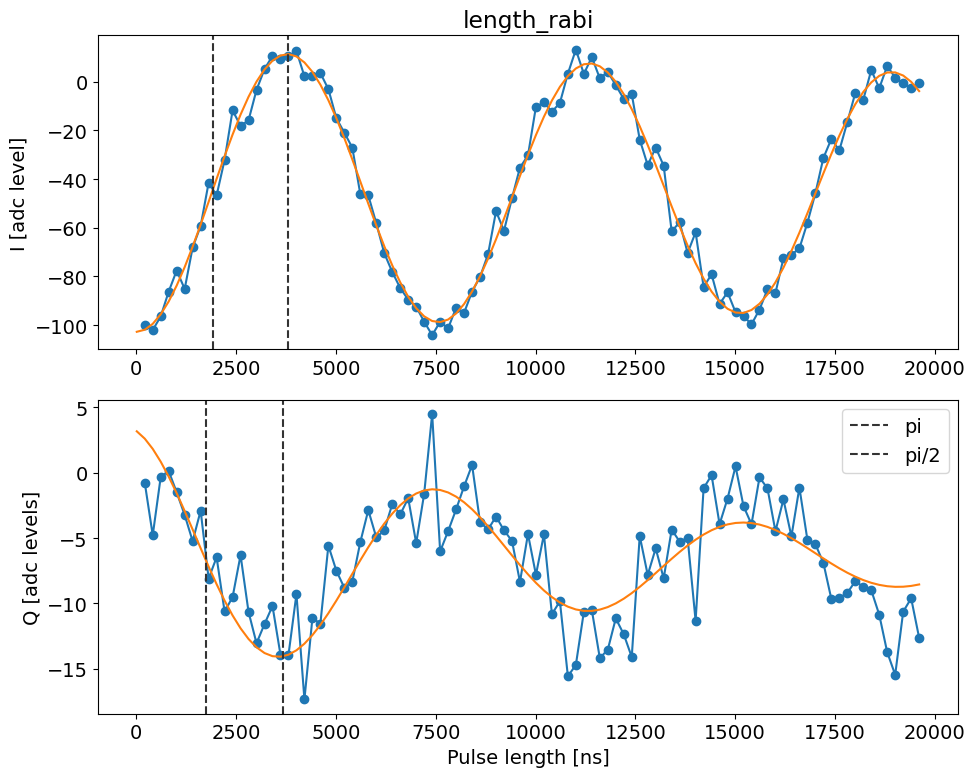

Fitted ac Stark shift: 0.1321863630001821 MHz
Updated ac Stark shift for mode 1: -1.3578302851822388 -> -1.2256439221820568


In [ ]:
parity_delay_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityDelayExperiment,
    default_expt_cfg=parity_delay_defaults,
    postprocessor=parity_delay_postproc,
    preprocessor=parity_delay_preproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

parity_delay_ac_stark = parity_delay_runner.execute(
    param_to_calib='ac_stark_shift', 
    go_kwargs=dict(analyze=False, display=False),
    step=0.2,
    expts=100,
    reps=100,
    shift_sign=+1,
)

Confirming the correction is in the right direction

In [ ]:
parity_delay_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityDelayExperiment,
    default_expt_cfg=parity_delay_defaults,
    preprocessor=parity_delay_preproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

parity_delay_ac_stark = parity_delay_runner.execute(
    param_to_calib='ac_stark_shift', 
    go_kwargs=dict(analyze=False, display=False),
    step=0.2,
    expts=100,
    reps=100,
)

Job submitted: JOB-20260128-00081 (queue position: 1)

[0.1s] Job JOB-20260128-00081: pending

[2.1s] Job JOB-20260128-00081: running
[WORKER] Loading ParityDelayExperiment from experiments.single_qubit.parity_phase
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260128-00081_ParityDelayExperiment.h5
[WORKER] Running experiment...
  0%|                                                  | 0/100 [00:00<?, ?it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  1%|▍                                         | 1/100 [00:00<00:34,  2.90it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  2%|▊                                         | 2/100 [00:00<00:33,  2.90it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  3%|█▎                                        | 3/100 [00:01<00:33,  2.89it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  4%|█▋                                        | 4/100 [00:01<00:33,  2.89it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  5%|██            

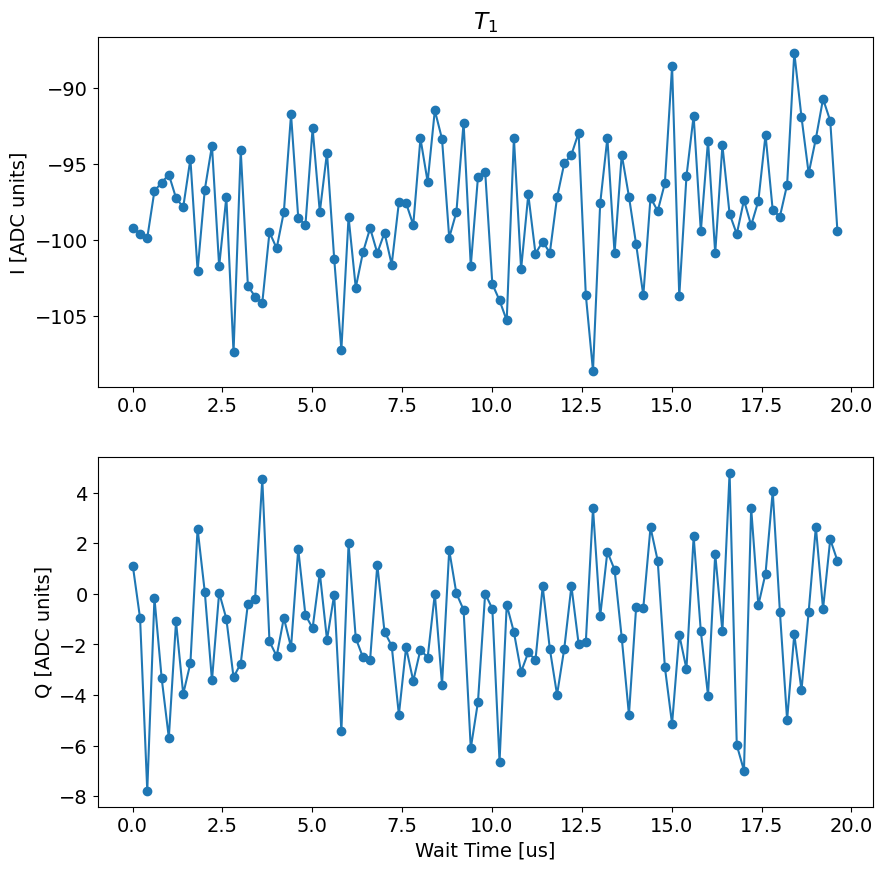

In [ ]:
parity_delay_ac_stark.display(fit=False)

### Now parity length after the AC stark shift is calibrated

Job submitted: JOB-20260128-00083 (queue position: 1)

[0.1s] Job JOB-20260128-00083: pending

[66.4s] Job JOB-20260128-00083: running
[WORKER] Loading ParityDelayExperiment from experiments.single_qubit.parity_phase
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260128-00083_ParityDelayExperiment.h5
[WORKER] Running experiment...
  0%|                                                  | 0/100 [00:00<?, ?it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  1%|▍                                         | 1/100 [00:00<01:00,  1.63it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  2%|▊                                         | 2/100 [00:01<00:59,  1.64it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  3%|█▎                                        | 3/100 [00:01<00:59,  1.64it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  4%|█▋                                        | 4/100 [00:02<00:58,  1.64it/s]sigma 0.007
f_ge 3563.8366942990683
gain 12602
  5%|██           

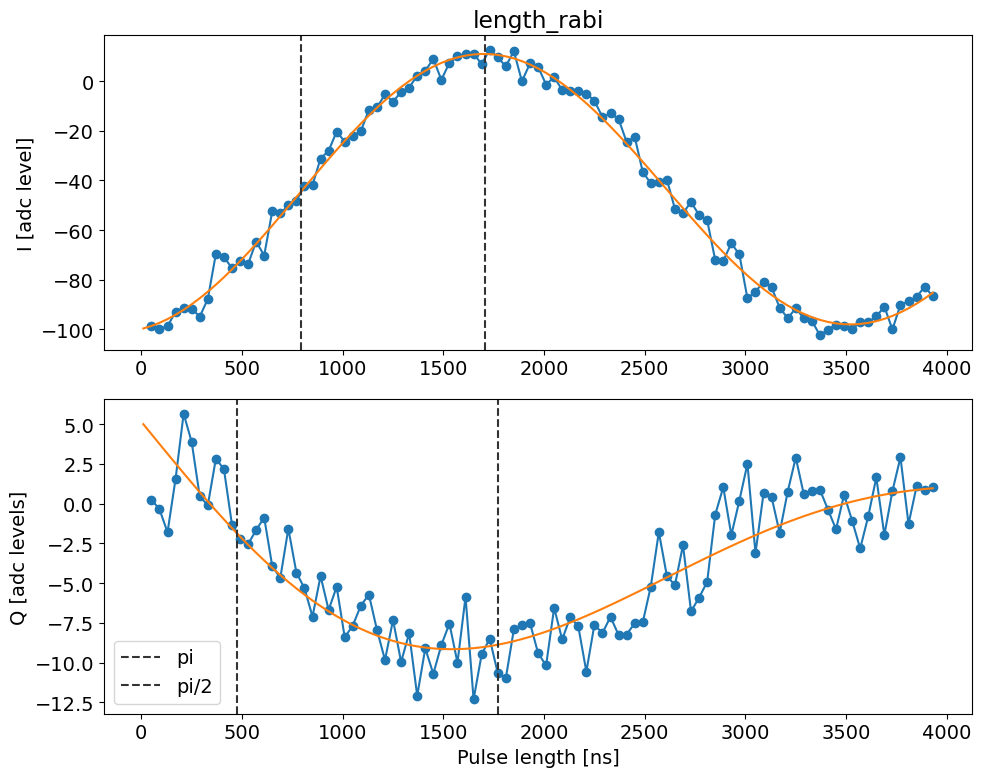

Fitted revival time: 1.705718471762309 us
Updated revival time for mode 1: 1.7208761780746338 -> 1.705718471762309


In [ ]:
parity_delay_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityDelayExperiment,
    default_expt_cfg=parity_delay_defaults,
    postprocessor=parity_delay_postproc,
    preprocessor=parity_delay_preproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

parity_delay_ac_stark = parity_delay_runner.execute(
    param_to_calib='length', 
    go_kwargs=dict(analyze=False, display=False),
    step=0.04,
    expts=100,
    reps=200,
)

## Manipulate Parity Spectroscopy

In [ ]:
parity_freq_defaults = AttrDict(dict(
    start=4960,
    stop=5020,
    step=0.60,
    reps=500,
    rounds=1,
    qubits=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=20,
    man_mode_no=1,
    displace=(True, 0.1, 1000),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500,
))

def parity_freq_postproc(station, expt):
    from fitting.fit_display_classes import Spectroscopy
    spec = Spectroscopy(expt.data, config=expt.cfg)
    spec.analyze()
    spec.display(title='Parity Frequency Experiment')

    expt_cfg = expt.cfg.expt
    man_mode_no = expt_cfg.man_mode_no
    fitted_freq = spec.data['fit_avgi'][2]
    old_freq = station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1]
    station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1] = fitted_freq
    print(f'Updated manipulate f_ge for mode {man_mode_no} from {old_freq} to {fitted_freq}')


parity_freq_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityFreqExperiment,
    default_expt_cfg=parity_freq_defaults,
    postprocessor=parity_freq_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)


Job submitted: JOB-20260128-00090 (queue position: 1)

[0.1s] Job JOB-20260128-00090: pending

[2.1s] Job JOB-20260128-00090: running
[WORKER] Loading ParityFreqExperiment from experiments.single_qubit.parity_freq
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260128-00090_ParityFreqExperiment.h5
[WORKER] Running experiment...
 98%|████████████████████████████████████████▏| 98/100 [02:17<00:02,  1.46s/it]
[146.9s] Job JOB-20260128-00090: completed
100%|████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]
Saving D:\experiments\260128_qsim\data\JOB-20260128-00090_ParityFreqExperiment.h5
[WORKER] Saving expt object to: D:\experiments\260128_qsim\expt_objs\JOB-20260128-00090_expt.pkl

Job completed! Data: D:\experiments\260128_qsim\data\JOB-20260128-00090_ParityFreqExperiment.h5
Found peak in amps at [MHz] 4979.917587251618, HWHM -0.335485631302184
Found peak in I at [MHz] 4979.779708970571, HWHM -1.5163809289474133
Found peak in Q at [MHz] 4979.710

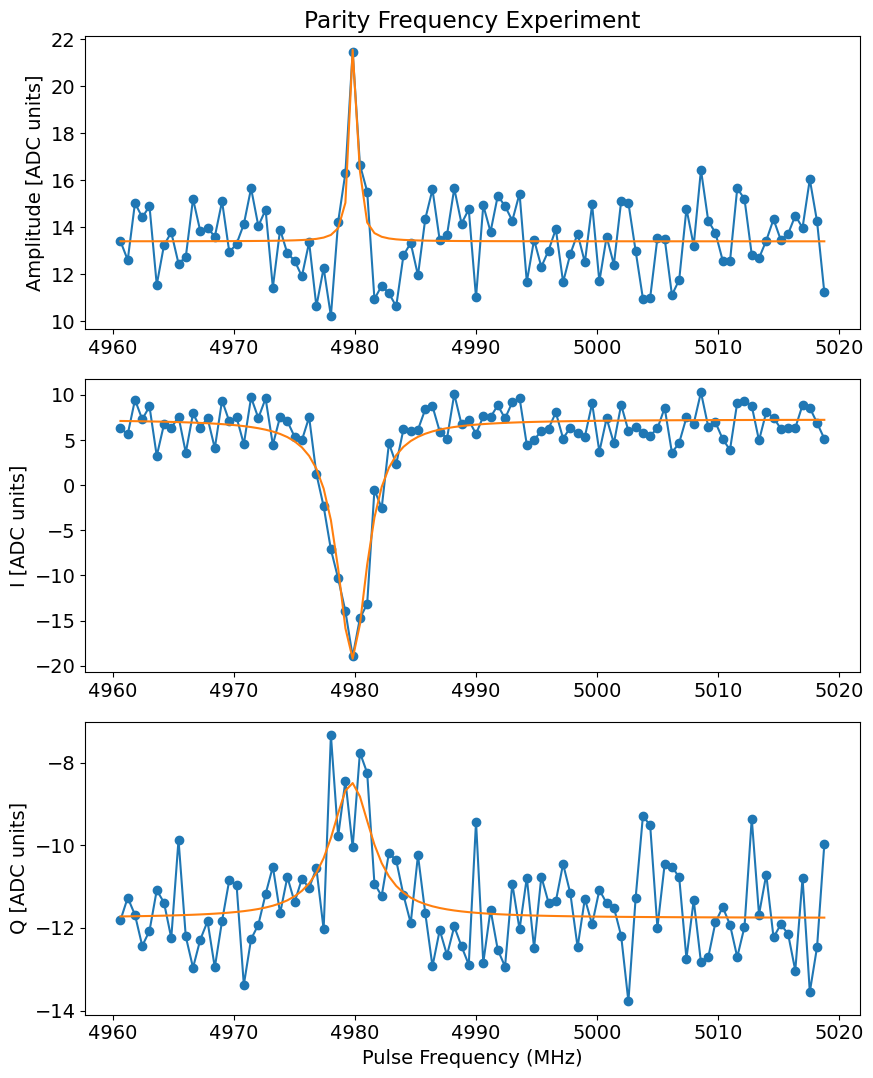

Updated manipulate f_ge for mode 1 from 4979.6251762775755 to 4979.779708970571


In [ ]:
parity_freq = parity_freq_runner.execute(
    go_kwargs=dict(analyze=False, display=False),
)

## Manipulate Ramsey (to finetune frequency)
- This will use displace pulse instead do qubit pi/2 to calibrate; we want fine calibration of manipulate frequency not some fast way of extracting T2 time or finding stark shift on f0g1 transition
- Make sure displacements are small $(\alpha \approx 0.2)$
- Somehow i don't get full contrast, like the lowst i,q value dont correspond to g 




In [ ]:
cavity_ramsey_defaults = AttrDict(dict(
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=200,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    reps=100,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    prep_e_first = True,
    relax_delay=2500      # relax delay
))

def cavity_ramsey_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    expt_cfg.man_idx = expt_cfg.man_mode_no - 1

    if expt_cfg.user_defined_pulse is None:
        expt_cfg.user_defined_pulse = [True, station.hardware_cfg.device.manipulate.f_ge[expt_cfg.man_mode_no-1], 10, station.hardware_cfg.device.manipulate.displace_sigma[expt_cfg.man_mode_no-1], 0, 4]

    if expt_cfg.man_ramsey is None:
        expt_cfg.man_ramsey = [False, expt_cfg.man_mode_no -1]
    if expt_cfg.custom_coupler_pulse is None:
        expt_cfg.custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if expt_cfg.pre_sweep_pulse is None:
        expt_cfg.pre_sweep_pulse = []
    if expt_cfg.post_sweep_pulse is None:
        expt_cfg.post_sweep_pulse = []
    # do we need to set the relax delay here?
    return expt_cfg

def cavity_ramsey_postproc(station, expt):

    from fitting.fit_display_classes import RamseyFitting
    ramsey_analysis = RamseyFitting(expt.data, config=expt.cfg)
    delta_f = min(ramsey_analysis.data['f_adjust_ramsey_avgi'])

    expt_cfg = expt.cfg.expt
    man_mode_no = expt_cfg.man_mode_no
    old_freq = station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1]
    station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1] = old_freq + delta_f
    print(f'Updated manipulate f_ge for mode {man_mode_no} from {old_freq} to {station.hardware_cfg.device.manipulate.f_ge[man_mode_no - 1]}')

cavity_ramsey_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.t2_cavity.CavityRamseyExperiment,
    default_expt_cfg=cavity_ramsey_defaults,
    preprocessor=cavity_ramsey_preproc,
    postprocessor=cavity_ramsey_postproc,
    job_client=client,
    user=user,    
    use_queue=USE_QUEUE,
)


# def do_cavity_ramsey_gain_sweep(
#     hardware_cfg,
#     expt_path,
#     config_path,
#     start=0.01,           # start delay
#     step=0.05,            # step size
#     expts=200,            # number of experiments
#     ramsey_freq=3.7,      # Ramsey frequency
#     gain_start = 1000,  # start gain
#     gain_step = 1000,      # step size for gain
#     gain_expts = 5,        # number of experiments for gain
#     reps=100,              # repetitions
#     rounds=1,             # rounds
#     qubits=[0],           # qubits
#     checkEF=False,        # check EF
#     f0g1_cavity=0,        # f0g1 cavity
#     init_gf=False,        # initialize gf
#     active_reset=False,   # active reset
#     man_reset=True,       # manipulate reset
#     storage_reset=True,   # storage reset
#     user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
#     parity_meas=True,     # parity measurement
#     man_mode_no=1,            
#     storage_ramsey=[False, 2, True], # storage Ramsey
#     man_ramsey=None,      # manipulate Ramsey
#     coupler_ramsey=False, # coupler Ramsey
#     custom_coupler_pulse=None, # custom coupler pulse
#     echoes=[False, 0],    # echoes
#     prepulse=False,       # prepulse
#     postpulse=False,      # postpulse
#     gate_based=False,     # gate based
#     pre_sweep_pulse=None, # pre sweep pulse
#     post_sweep_pulse=None,# post sweep pulse
#     relax_delay=2500,      # relax delay
#     do_g_and_e=False, # do e-f first
# ):
#     """
#     Run the Cavity Ramsey experiment using the specified configuration.
#     """
#     if user_defined_pulse is None:
#         user_defined_pulse = [True, station.hardware_cfg.device.manipulate.f_ge[man_mode_no-1], 1000, station.hardware_cfg.device.manipulate.displace_sigma[man_mode_no-1], 0,
#                                   4]
#     #[on/off, freq, gain, sigma (mus), phase, channel] 
#     if man_ramsey is None:
#         man_ramsey = [False, man_mode_no -1]
#     if custom_coupler_pulse is None:
#         custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
#     if pre_sweep_pulse is None:
#         pre_sweep_pulse = []
#     if post_sweep_pulse is None:
#         post_sweep_pulse = []

#     cavity_ramsey = expts_base_inst.meas.single_qubit.t2_cavity.CavityRamseyGainSweepExperiment(
#         soccfg=expts_base_inst.soc, path=expt_path, prefix='CavityRamseyGainSweepExperiment', config_file=config_path
#     )

#     cavity_ramsey.cfg = AttrDict(deepcopy(hardware_cfg))

#     cavity_ramsey.cfg.expt = dict(
#         start=start,                    # start delay
#         step=step,                      # step size
#         expts=expts,                    # number of experiments
#         ramsey_freq=ramsey_freq,        # Ramsey frequency
#         gain_start=gain_start,          # start gain
#         gain_step=gain_step,            # step size for gain
#         gain_expts=gain_expts,          # number of experiments for gain
#         reps=reps,                      # repetitions
#         rounds=rounds,                  # rounds
#         qubits=qubits,                  # qubits
#         checkEF=checkEF,                # check EF
#         f0g1_cavity=f0g1_cavity,        # f0g1 cavity
#         init_gf=init_gf,                # initialize gf
#         active_reset=active_reset,      # active reset
#         man_reset=man_reset,            # manipulate reset
#         storage_reset=storage_reset,    # storage reset
#         user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
#         parity_meas=parity_meas,        # parity measurement
#         man_mode_no=man_mode_no,                # manipulate index
#         storage_ramsey=storage_ramsey,  # storage Ramsey
#         man_ramsey=man_ramsey,          # manipulate Ramsey
#         coupler_ramsey=coupler_ramsey,  # coupler Ramsey
#         custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
#         echoes=echoes,                  # echoes
#         prepulse=prepulse,              # prepulse
#         postpulse=postpulse,            # postpulse
#         gate_based=gate_based,          # gate based
#         pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
#         post_sweep_pulse=post_sweep_pulse, # post sweep pulse
#         do_g_and_e=do_g_and_e,  # do e-f first
#     )

#     cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
#     cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
#     return cavity_ramsey



100


  0%|          | 0/50000 [00:00<?, ?it/s]

No echoes in the data
Saving D:\experiments\250119_qec\data\00009_CavityRamseyExperiment.h5
Using user defined frequency: 4979.614305651117 MHz
Current pi pulse frequency: 4979.614305651117
Fit frequency from I [MHz]: 0.4980162529435449 +/- 0.0026728238107538074
Suggested new pi pulse frequency from fit I [MHz]:
 	4979.616289398174
 	4980.612321904061
T2 Ramsey from fit I [us]: 71.75481002663035
Fit frequency from Q [MHz]: 0.48893360693068166 +/- 0.004804504006061256
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4979.625372044186
 	4980.603239258048
T2 Ramsey from fit Q [us]: 7398.6769048551


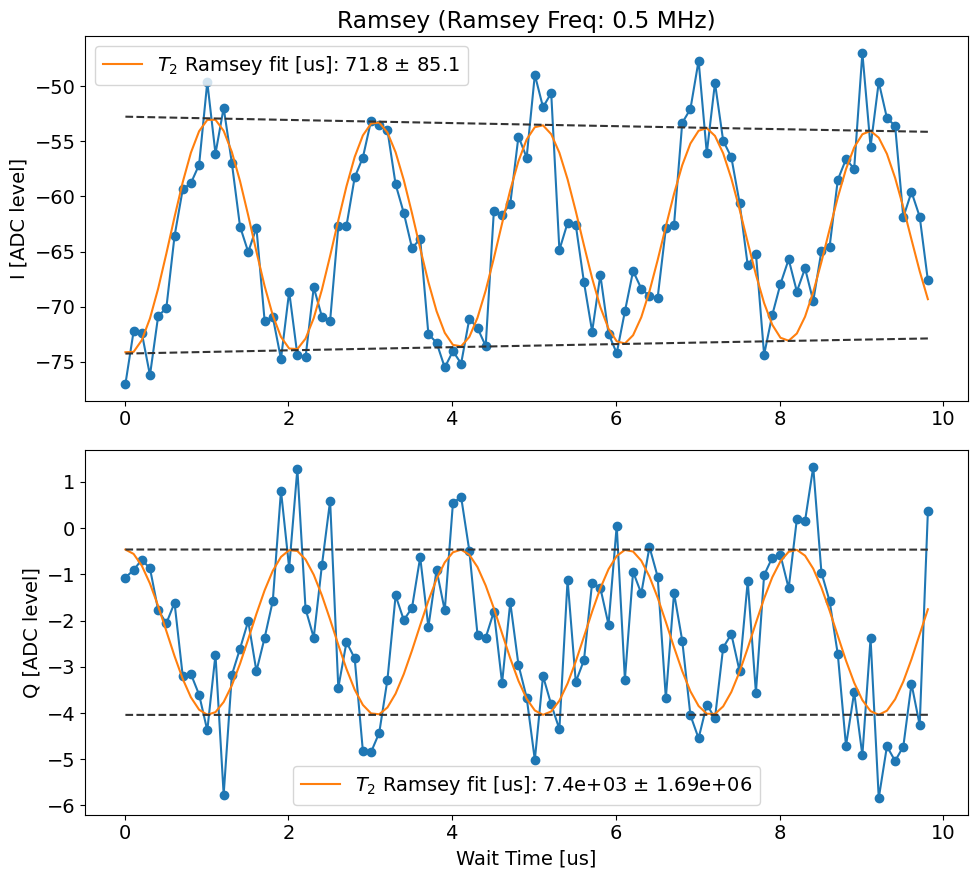

Updated manipulate f_ge for mode 1 from 4979.614305651117 to 4979.616289398174


In [ ]:
station.hardware_cfg.device.manipulate.f_ge[0]=4979.614305651117

cavity_ramsey = cavity_ramsey_runner.execute(
    ramsey_freq=0.5,
    step = 0.1,
    expts = 100,
    reps = 500,
    prep_e_first = False,
    user_defined_pulse=[True, station.hardware_cfg.device.manipulate.f_ge[0], 2000, 
                                station.hardware_cfg.device.manipulate.displace_sigma[0],
                                  0, 4],
)

In [ ]:
if USE_QUEUE:
    cavity_ramsey.display()

## Gain to alpha calibration

will do tomography on the vacuum state

$$
W_\alpha(\ket{0} \bra{0}) = \frac 2\pi e^{-2|\alpha|^2}
$$

In [5]:
do_parity_gain_defaults = AttrDict(dict(
    start=0,
    step=100,
    expts=40,
    reps=250,
    rounds=1,
    qubit=0,
    qubits=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=1000,
    singleshot_active_reset=False,
    singleshot_man_reset=True,
    singleshot_storage_reset=True,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    span=1000,
    prep_e=False,
    manipulate=1,
    displace=(True, 0.05), # [enable, sigma] (gaussian length is 4sigma)
    const_pulse=(False, 1), # [enable, length]
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500, 
    pulse_correction=False,
    parity_fast=True,
    scaling_amplitude=True,
    plot_IQ=True,
    man_mode_no=1,
))


def parity_gain_postproc(station, expt):
    expt_cfg = expt.cfg.expt
    scaling_amplitude = expt_cfg.scaling_amplitude
    man_mode_no = expt_cfg.man_mode_no
    if expt_cfg.plot_IQ:
        i_data = expt.data['idata']
        q_data = expt.data['qdata']
        fig, ax = plt.subplots(1,1, figsize=(6,6))
        ax.scatter(i_data, q_data, s=1, alpha=0.5)
        ax.set_xlabel('I')
        ax.set_ylabel('Q')
        ax.set_title('IQ Scatter Plot')
        plt.show()
    gain_to_alpha = expt.data['gain_to_alpha']
    old_gain_to_alpha = station.hardware_cfg.device.manipulate.gain_to_alpha[expt_cfg.man_mode_no - 1]
    print(f'Gain to alpha for mode {expt_cfg.man_mode_no} : {old_gain_to_alpha} -> {gain_to_alpha}')
    station.hardware_cfg.device.manipulate.gain_to_alpha[man_mode_no - 1] = gain_to_alpha
    if scaling_amplitude:
        scale = expt.data['scale']
        old_scale = station.hardware_cfg.device.manipulate.alpha_scale[man_mode_no - 1]
        station.hardware_cfg.device.manipulate.alpha_scale[man_mode_no - 1] = scale
        print(f'Scaling amplitude for mode {man_mode_no} : {old_scale} -> {scale}')




Job submitted: JOB-20260203-00141 (queue position: 1)

[0.1s] Job JOB-20260203-00141: pending

[2.1s] Job JOB-20260203-00141: running
[WORKER] Loading ParityGainExperiment from experiments.single_qubit.parity_gain
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260203-00141_ParityGainExperiment.h5
[WORKER] Running experiment...
['qubit', 'ge', 'hpi', 0]
['wait', 1.6371885401046262]
['qubit', 'ge', 'hpi', 180]
4979.779708970571
Updating gain register 250
100%|███████████████████████████████████| 10000/10000 [00:25<00:00, 399.23it/s]
['qubit', 'ge', 'hpi', 0]
['wait', 1.6371885401046262]
['qubit', 'ge', 'hpi', 180]
4979.779708970571
Updating gain register 250
 82%|█████████████████████████████▍      | 8190/10000 [00:20<00:04, 399.20it/s]
[58.5s] Job JOB-20260203-00141: completed
100%|███████████████████████████████████| 10000/10000 [00:25<00:00, 399.21it/s]
plot: False
Gain to Alpha Conversion Factor: 0.00025333959203972724
alpha = 1 requires gain of : 3947.27090207
Sav

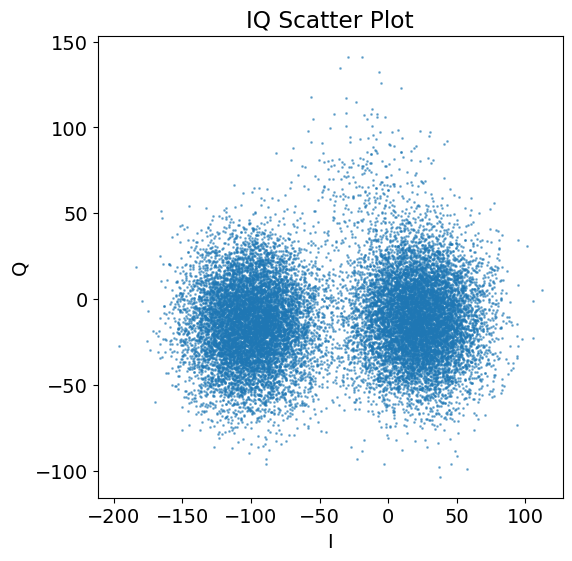

Gain to alpha for mode 1 : 0.0002580761220461459 -> 0.00025333959203972724
Scaling amplitude for mode 1 : 0.8423926897240561 -> 0.8538000151222552


In [6]:
parity_gain_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.parity_gain.ParityGainExperiment,
    default_expt_cfg=do_parity_gain_defaults,
    postprocessor=parity_gain_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

parity_gain_expt = parity_gain_runner.execute(
    pulse_correction=True, # if number of photons in man is large, pi/2 pulses are bad. therefore, if pulse_correction = True: do a second set of parity measurements using pi/2, wait, -pi/2 and take the contrast between this measurement and the standard pi/2, wait, pi/2 parity measurement.
    reps=250,
    step=250,
    go_kwargs=dict(analyze=False, display=False),
    )


plot: True
Gain to Alpha Conversion Factor: 0.00025333959203972724


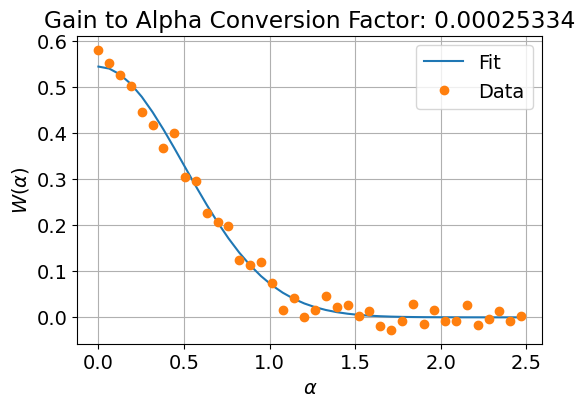

alpha = 1 requires gain of : 3947.27090207


In [7]:
if USE_QUEUE: 
    parity_gain_expt.analyze(scale=True, plot=True)

In [ ]:
parity_gain_expt.data.keys()

dict_keys(['xpts', 'avgi', 'avgq', 'amps', 'phases', 'idata', 'qdata', 'gain_to_alpha', 'parity', 'scale'])

In [ ]:
station.hardware_cfg.device.manipulate.gain_to_alpha[0] = parity_gain_expt.data['gain_to_alpha']
station.hardware_cfg.device.manipulate.alpha_scale[0] = parity_gain_expt.data['scale']

In [ ]:
station.snapshot_hardware_config(update_main=True)

[CONFIG] Created new hardware_config version CFG-HW-20260128-00013
[CONFIG] Updated main hardware_config to CFG-HW-20260128-00013


'CFG-HW-20260128-00013'

# Qsim Wigner Tomography

## Generate Optimal Displacements 

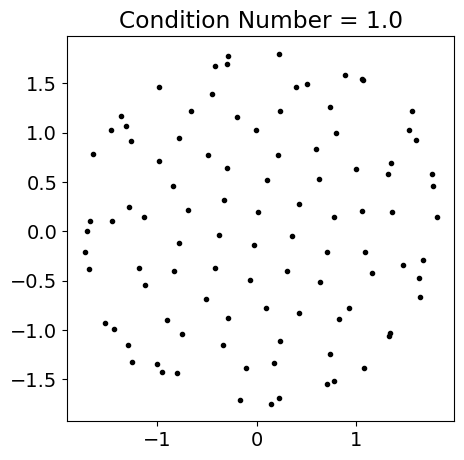

Displacements saved to D:\experiments\260128_qsim\optimized_displacements_5.npy


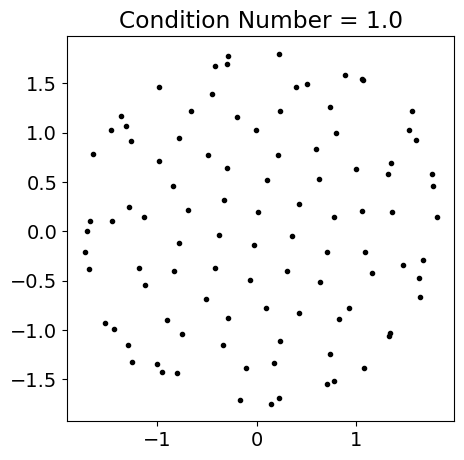

In [30]:
from fitting.wigner import OptimalDisplacementGeneration
n_photon = 5 # maximum photon number to consider
n_disps = 100 # number of displacements to use in the optimization
opt_alphas = OptimalDisplacementGeneration(FD = n_photon, n_disps=n_disps)
return_dict = opt_alphas.optimize(save_dir = station.experiment_path)


# Setup experiment

In [31]:
kerr_wait_wigner_defaults = AttrDict(dict(
    expts=1,
    reps=100,
    rounds=1,
    qubits=[0],
    ro_stor=0, # storage mode number that gets read out in the end

    init_fock=False,
    displacement_path=return_dict['path'], # optimal displacement path
    perform_wigner=True,
    parity_fast=True,
    pulse_correction=True,

    wait_us_times=np.linspace(0, 5, 10).tolist(),
    swept_params = ['wait_us_time'],

    # Use SweepRunner to handle the sweeping
    # dummys=[0],
    # swept_params=['dummy'],

    normalize=False,
    post_select_pre_pulse=False,
    active_reset=False,
    man_reset=False, 
    storage_reset=False, 
    prepulse=True,
    postpulse=True,
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def kerr_wait_wigner_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    assert 'init_stor' in kwargs
    if not expt_cfg.init_fock:
        assert 'init_alpha' in kwargs

    print(expt_cfg)
    return expt_cfg


# wigner_runner = SweepRunner(
#     station=station,
#     ExptClass=meas.QsimWignerBaseExperiment,
#     ExptProgram=meas.KerrWaitProgram,
#     default_expt_cfg=kerr_wait_wigner_defaults,
#     sweep_param='wait_us_time',
#     preprocessor=kerr_wait_wigner_preproc,
#     postprocessor=None,
#     job_client=client,
# )

wigner_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.QsimWignerBaseExperiment,
    ExptProgram=meas.KerrWaitProgram,
    default_expt_cfg=kerr_wait_wigner_defaults,
    preprocessor=kerr_wait_wigner_preproc,
    postprocessor=None,
    job_client=client,
)

In [32]:
wigner = wigner_runner.execute(
    reps=50,
    init_fock=False,
    init_alpha=1.0,
    init_stor=0,
    ro_stor=0,
    relax_delay=2500, 

    wait_us_times=np.linspace(0, 10, 11).tolist(),

    # sweep_start=0,
    # sweep_stop=5,
    # sweep_npts=3,
)

{'expts': 1, 'reps': 50, 'rounds': 1, 'qubits': [0], 'ro_stor': 0, 'init_fock': False, 'displacement_path': 'D:\\experiments\\260128_qsim\\optimized_displacements_5.npy', 'perform_wigner': True, 'parity_fast': True, 'pulse_correction': True, 'wait_us_times': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], 'swept_params': ['wait_us_time'], 'normalize': False, 'post_select_pre_pulse': False, 'active_reset': False, 'man_reset': False, 'storage_reset': False, 'prepulse': True, 'postpulse': True, 'init_alpha': 1.0, 'init_stor': 0, 'relax_delay': 2500}
Job submitted: JOB-20260203-00179 (queue position: 1)

[0.1s] Job JOB-20260203-00179: pending

[66.5s] Job JOB-20260203-00179: running
[WORKER] Loading QsimWignerBaseExperiment from experiments.qsim.qsim_base_wigner
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260203-00179_QsimWignerBaseExperiment.h5
[WORKER]   Program: KerrWaitProgram from experiments.qsim.kerr
[WORKER] Running experiment...
 98%|███████████████

In [ ]:
# test_wigner = meas.QsimWignerBaseExperiment(config_file=station.hardware_config_file, expt_params=kerr_wait_wigner_defaults)
# test_wigner.data = wigner.data
# test_wigner.outer_params = wigner.outer_params
# test_wigner.inner_params = wigner.inner_params
# test_wigner.outer_param = wigner.outer_param
# test_wigner.inner_param = wigner.inner_param
# test_wigner.pulse_correction = wigner.pulse_correction
# test_wigner.cfg = deepcopy(wigner.cfg)

# test_wigner.analyze_wigner(mode_state_num=10)

0.0 None
shape (101, 50)
max parity: 1.0266032789986026
max parity before scaling: 0.8648030974751685
1.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 0.8858958559501726
2.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 0.759339305100148
3.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 0.8858958559501726
4.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 0.8437103390001642
5.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 0.8015248220501562
6.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 0.8858958559501726
7.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 0.8437103390001642
8.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 0.8015248220501562
9.0 None
shape (101, 50)
max parity: 1.0516423833644222
max parity before scaling: 

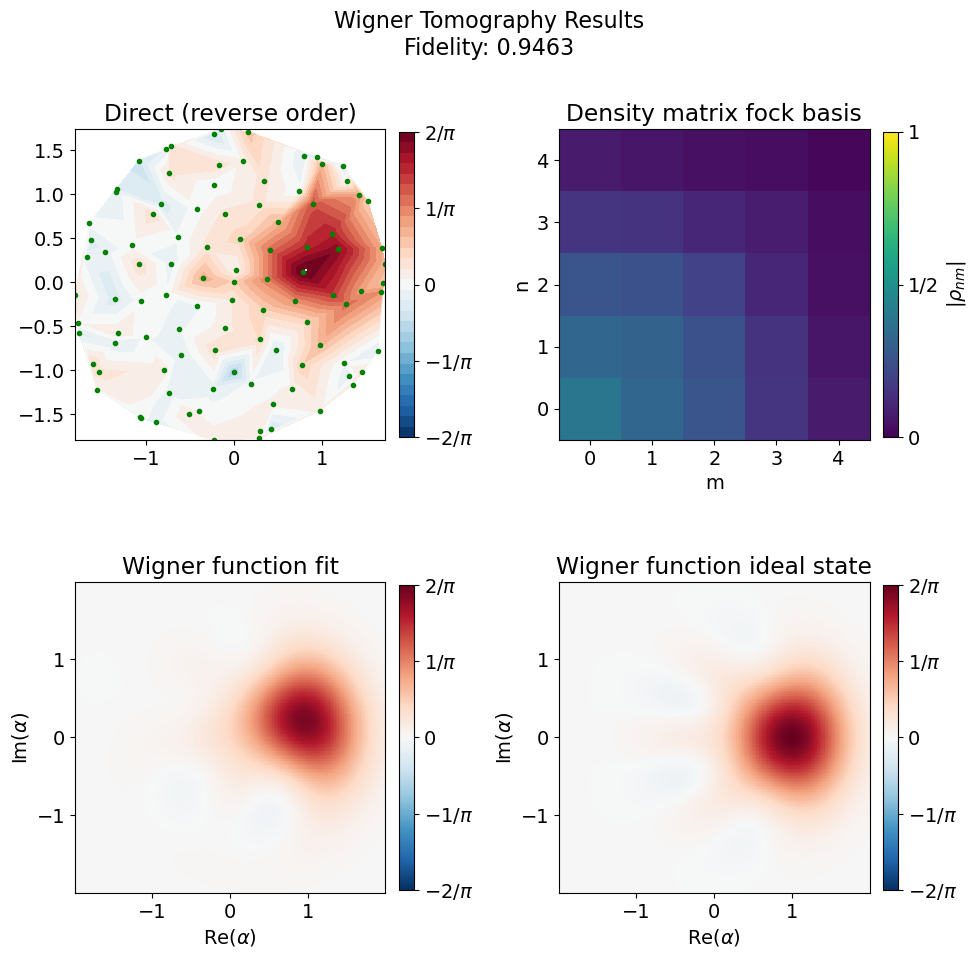

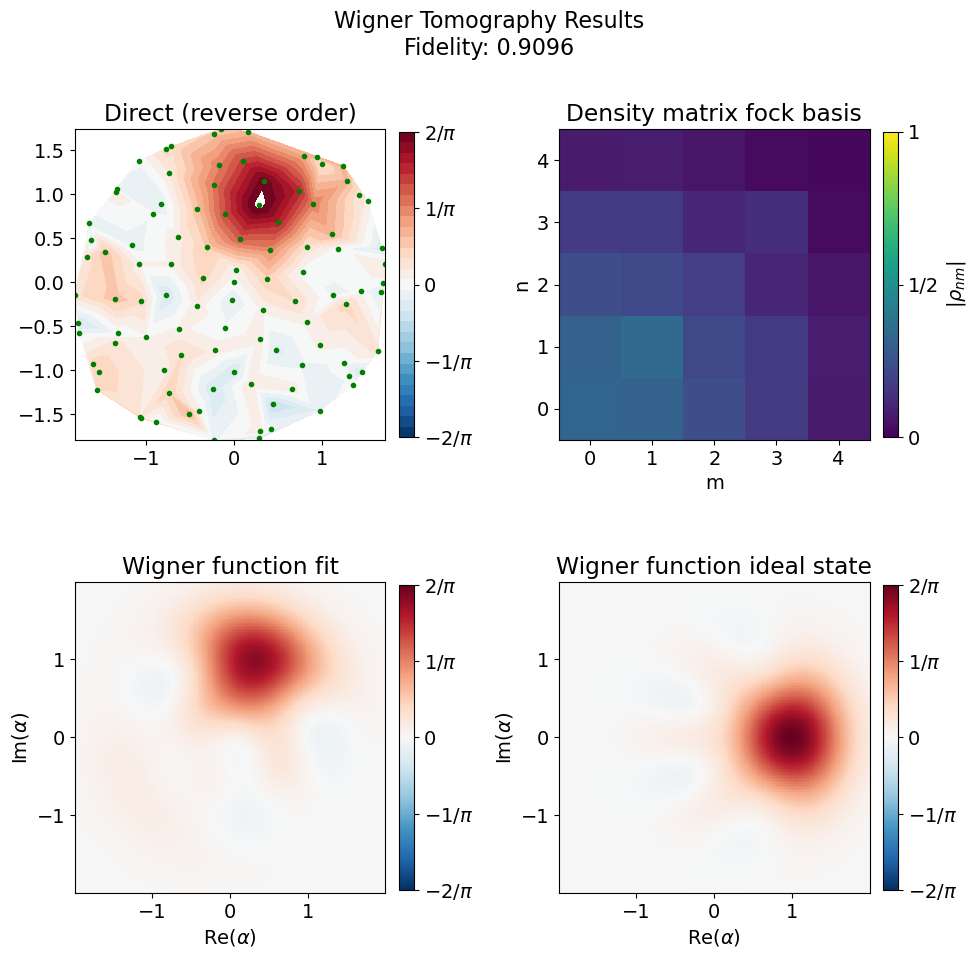

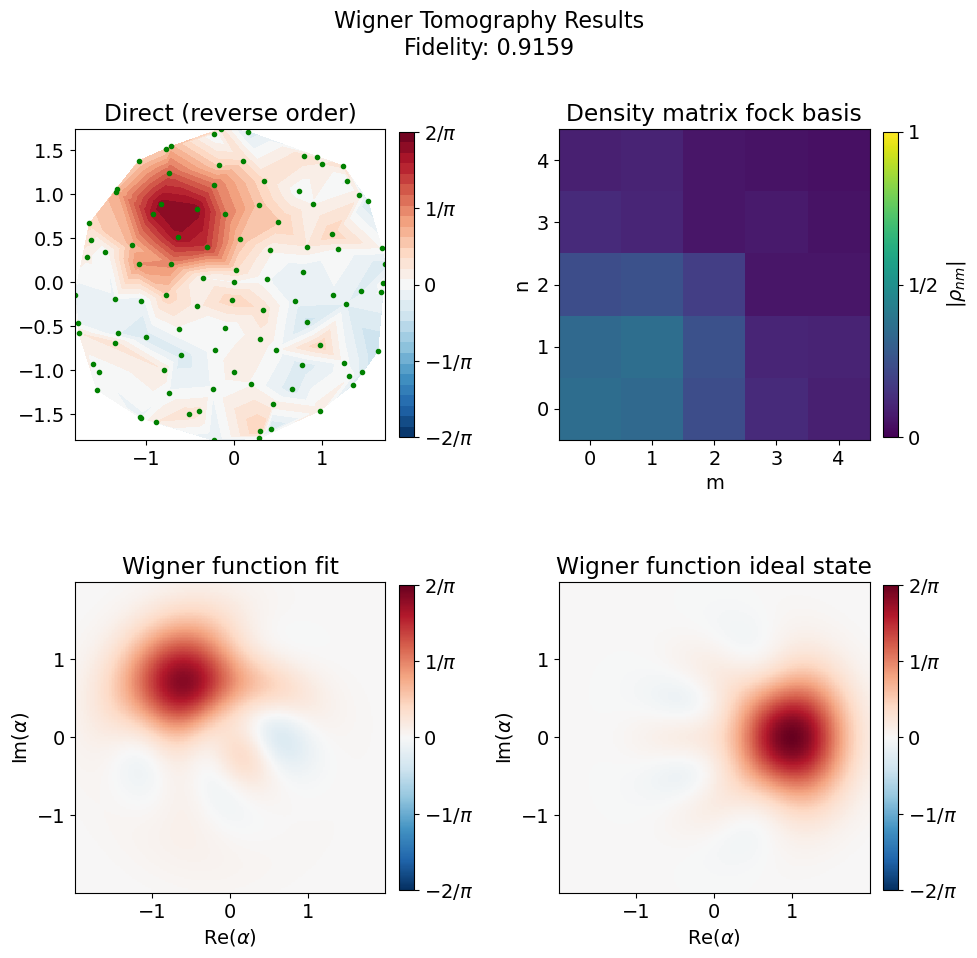

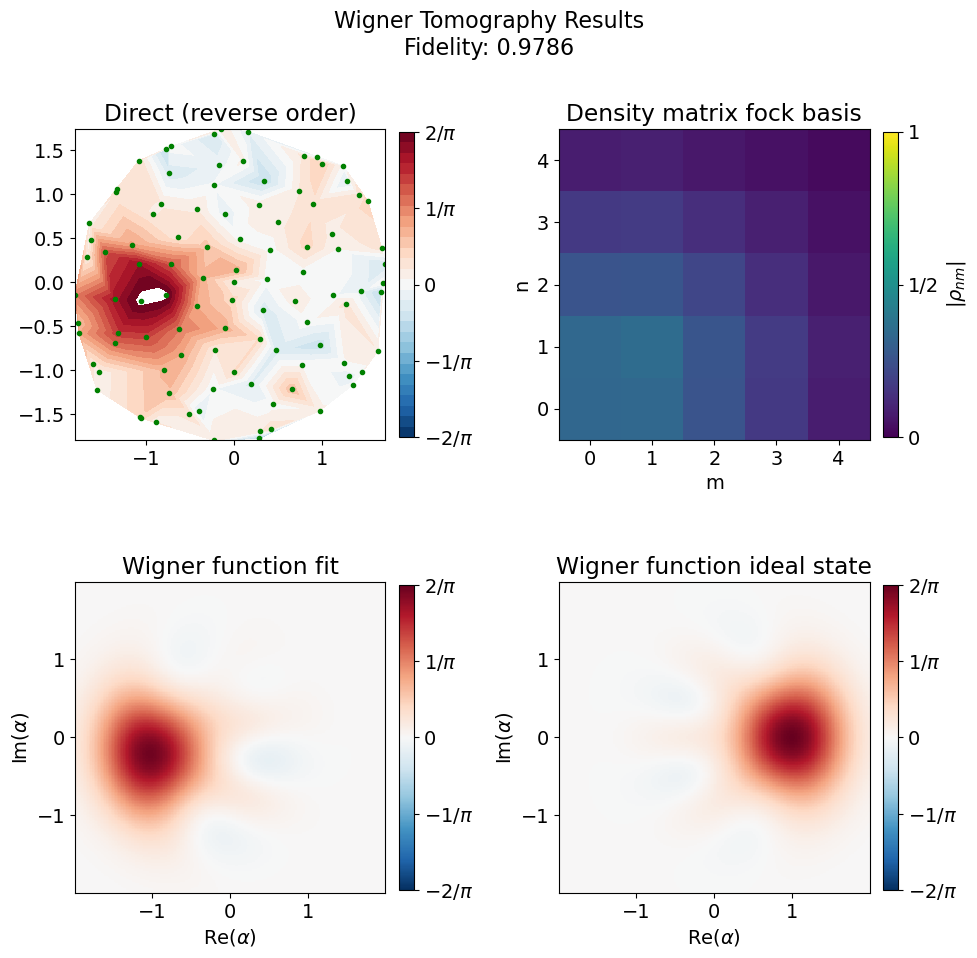

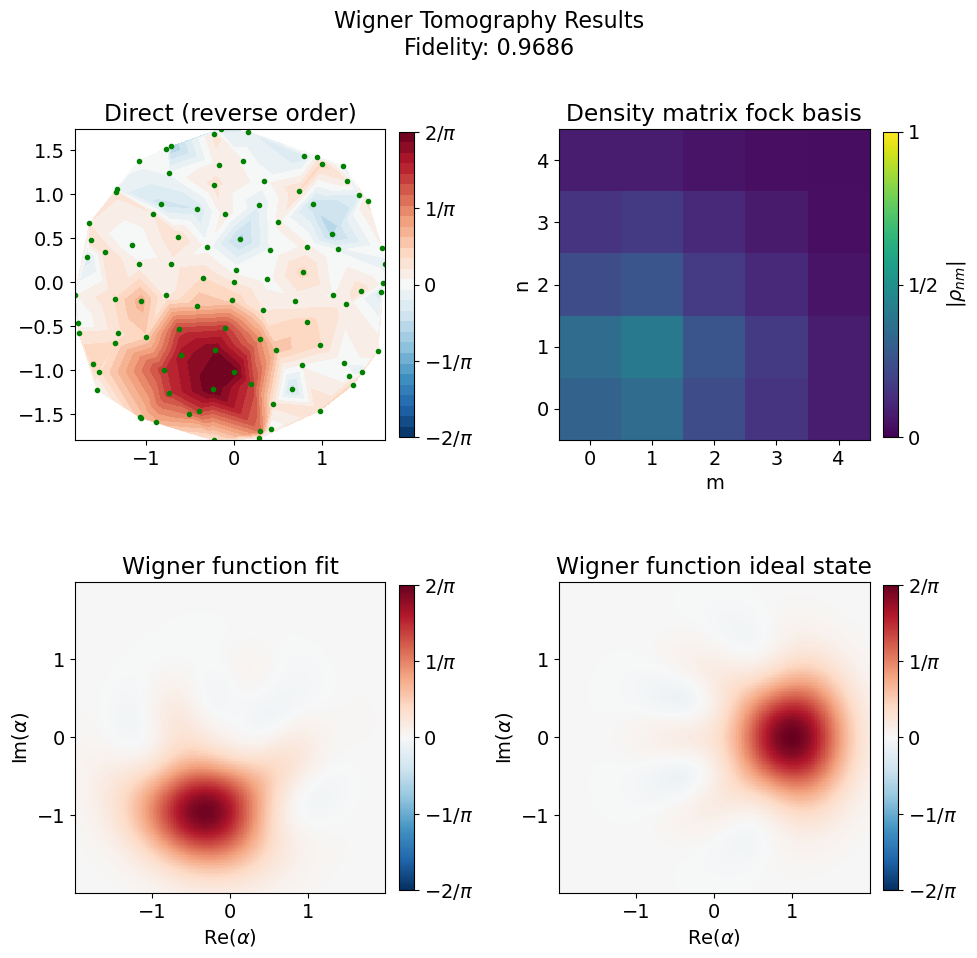

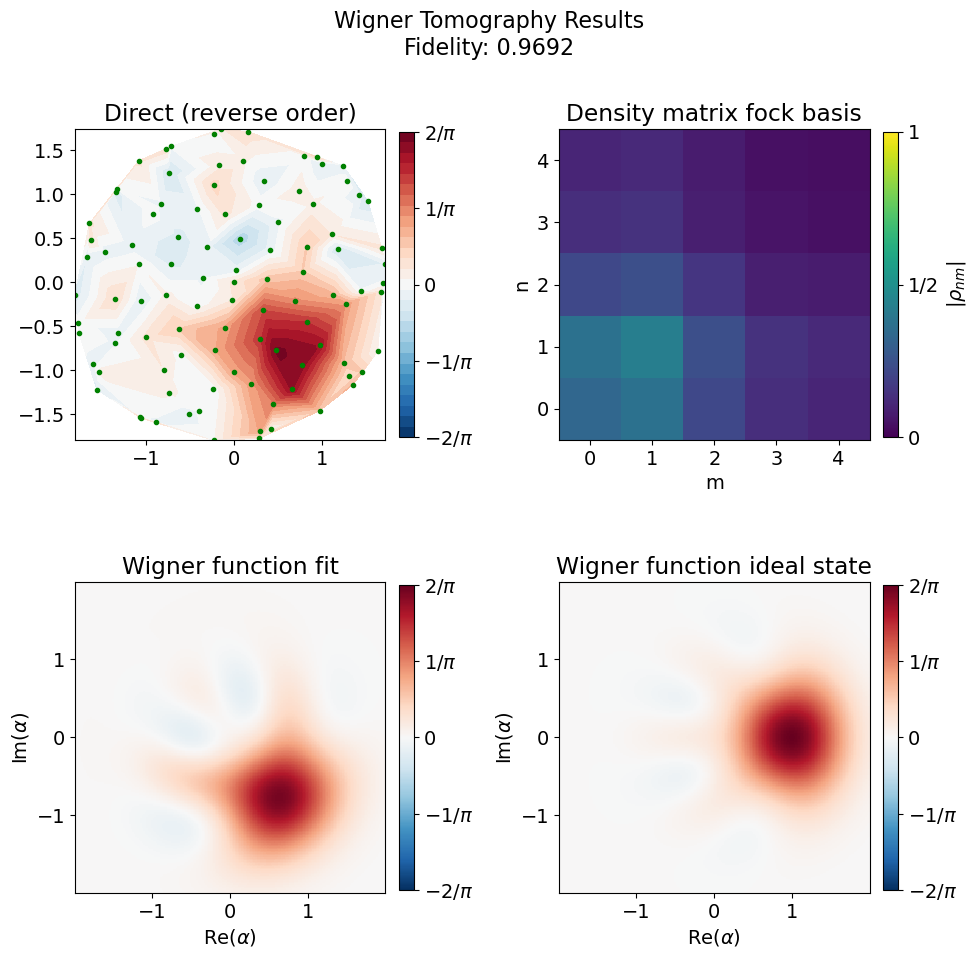

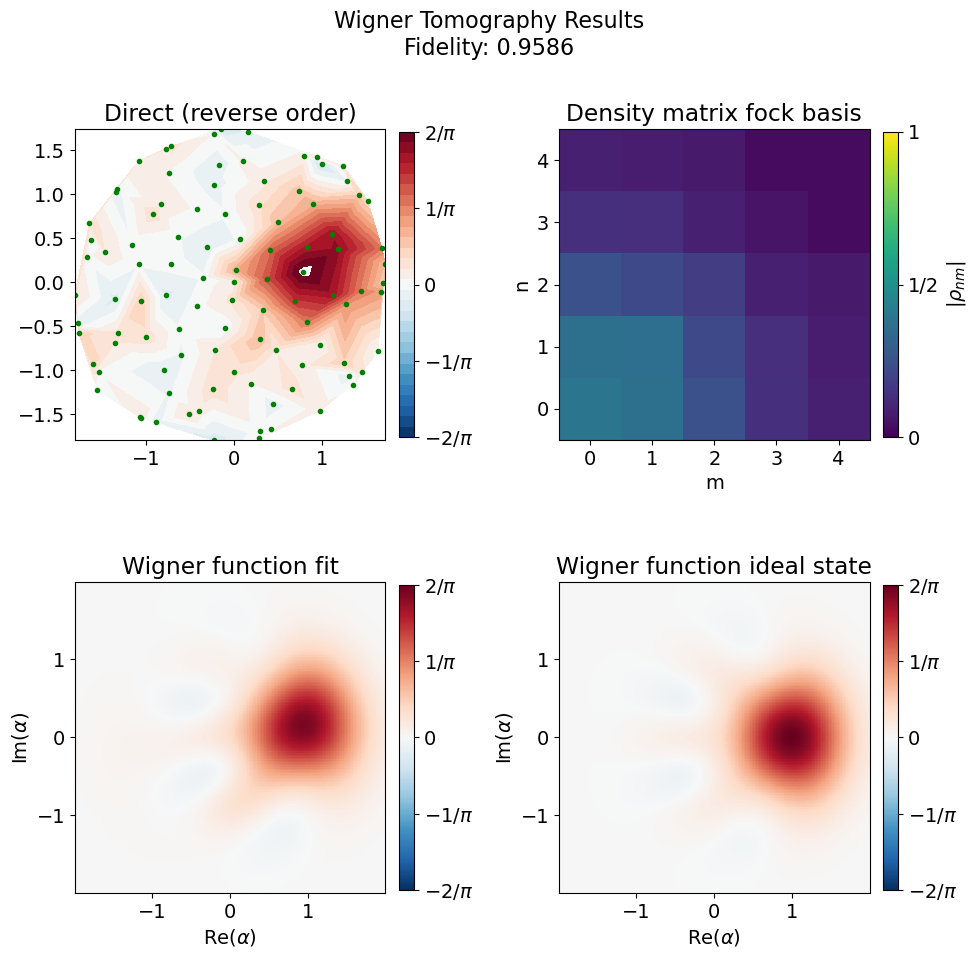

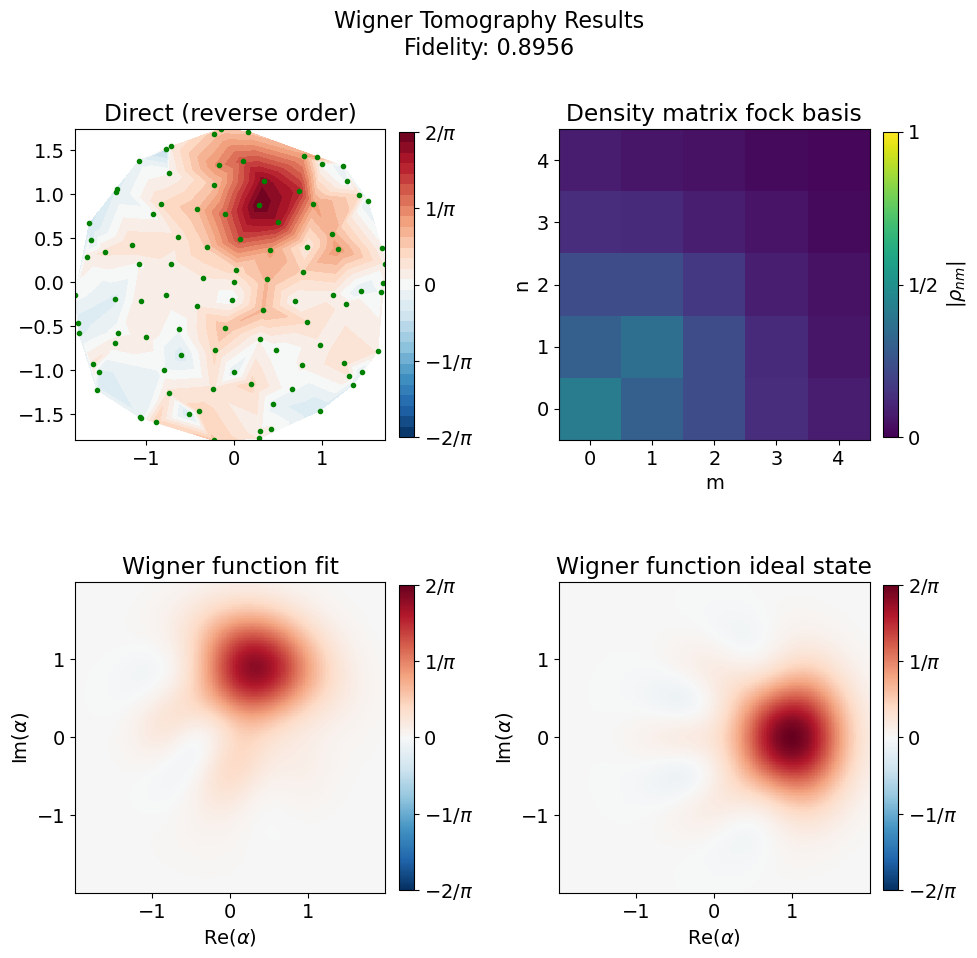

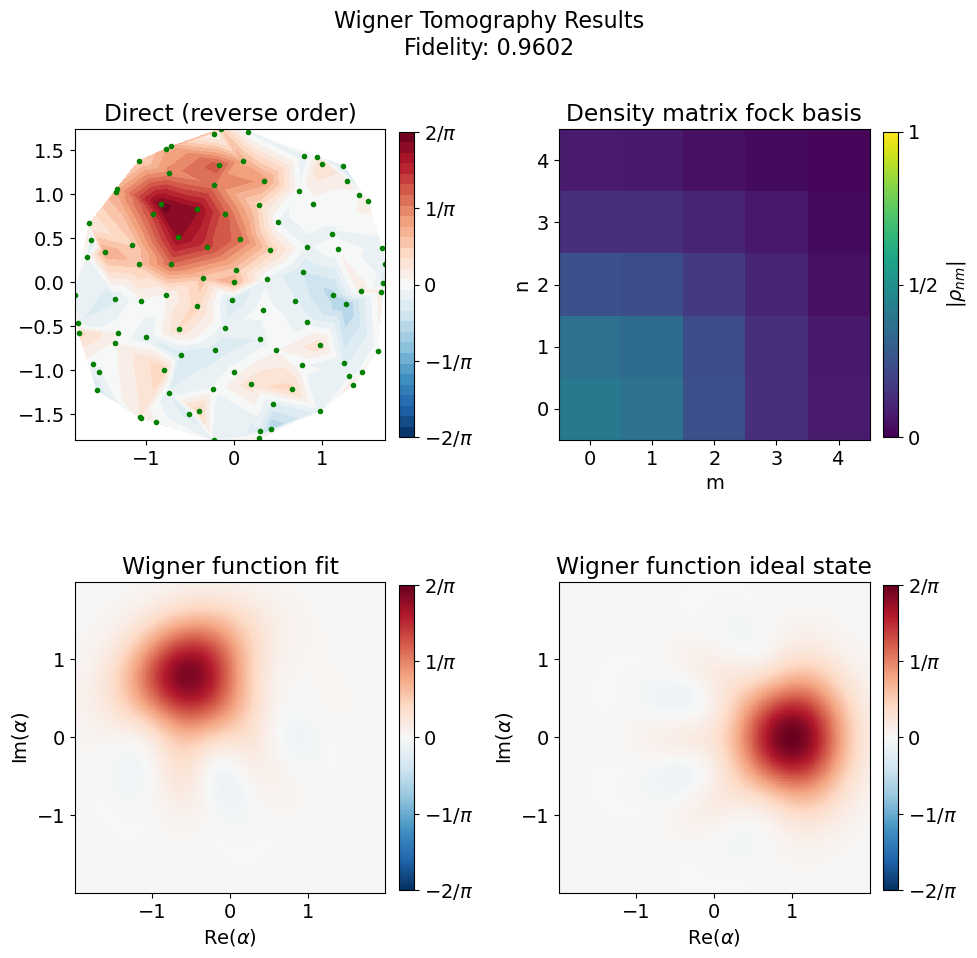

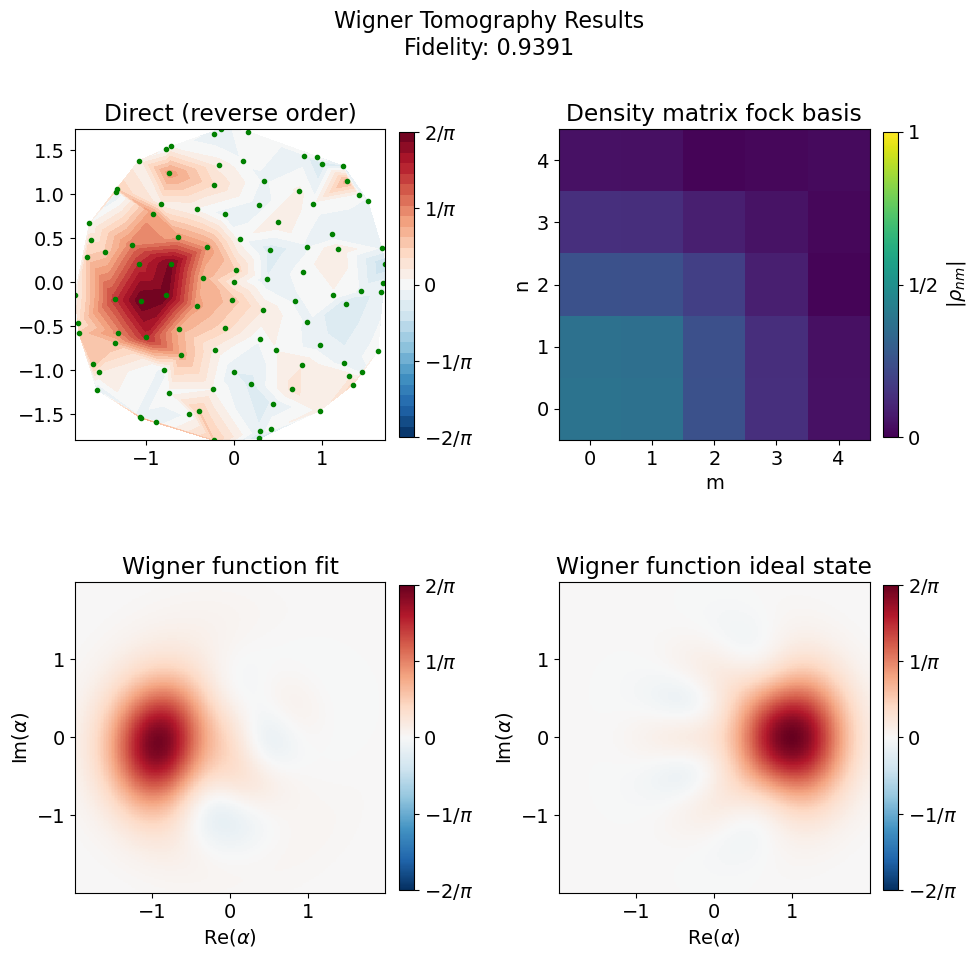

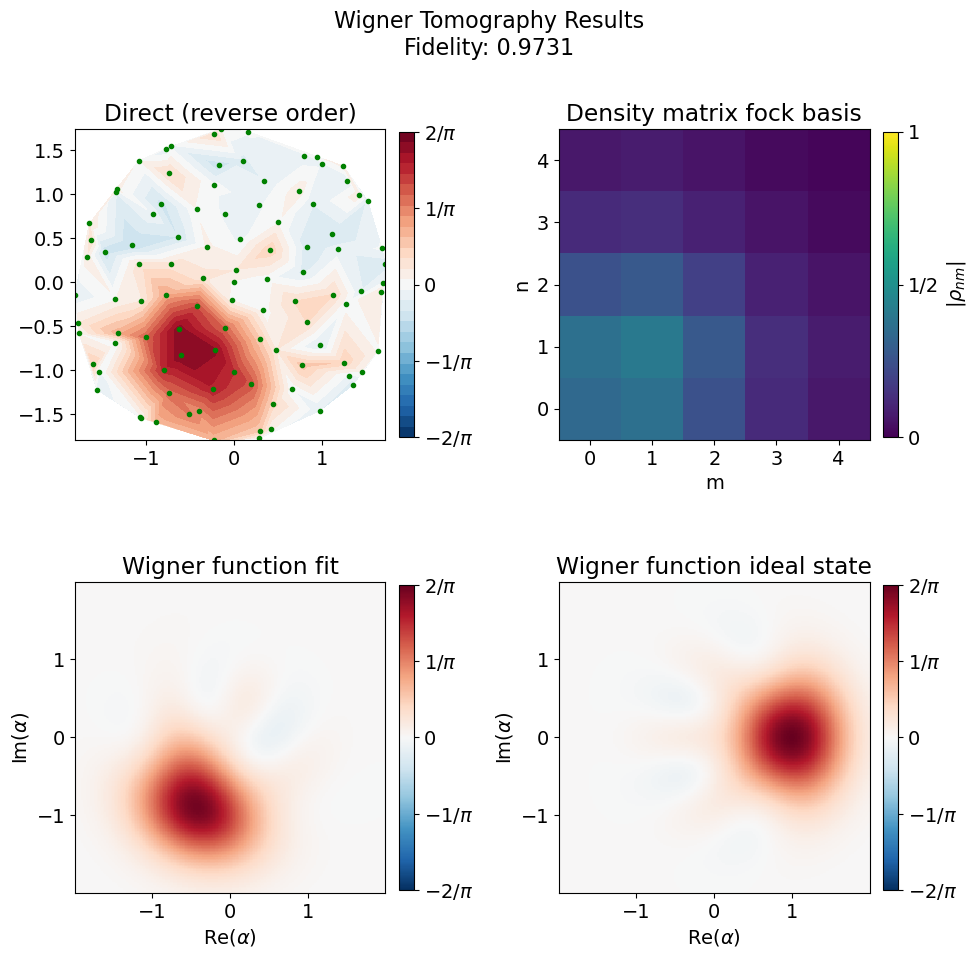

In [33]:
cutoff = 5
# ideal_state = (qt.basis(cutoff, 0)+qt.basis(cutoff, 4)).unit()
ideal_state = (qt.coherent(cutoff, 1.0)).unit()
wigner.analyze_wigner(cutoff=cutoff, debug=True)
wigner.display(rotate=True, initial_state=ideal_state, mode_state_num=cutoff, station=station, save_fig=False)
